In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_log_error
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [ ]:
#Train.csv и Test.csv
#date - дата продажа
#store_nbr - id магазина, где был продан товар
#family - семейство продуктов
#sales - общие продажи семейства продуктов в магазине на дату
#onpromotion - общее кол-во товаров семейства, которые продавались в магазине в тот день

#Stores.csv
#store_nbr - id магазина
#city - город магазина
#state - область, в которой расположен магазин
#type - тип магазина
#cluster - объединение похожих магазинов

#Oil.csv
#date - дата курса
#dcoilwtico - курс нефти

#Holidays_events.csv
#date - дата праздника
#type - тип праздника (Holiday - оф. праздник; Transfer - перенос праздника; Additional - доп дни; Bridge - перенос дней;
#                      Work Day - день отработки переноса; Event - событие)
#locale - уровень праздника (местный, региональный, национальаный)
#locale_name - местность, где празднуют
#description - описание
#transferred - был ли перенос

#! ЗП в гос. секторе выплачиваются 15 числа и в последнее число месяца
#!! 16.04.2016 было сильное землятрясение. Несколько недель люди помогали пострадавшим водой и вещами первой необходимости

In [5]:
#Метод для создания соседних к празднику дней
def make_neighbour_days(df_holidays, holiday_name, days_range):
    df_res = pd.DataFrame()
    holidays_dates = df_holidays[df_holidays['description']==holiday_name]['date']
    for step in range(-days_range, days_range+1):
        new_dates = holidays_dates.apply(lambda x: x+np.timedelta64(step,'D'))
        new_names = pd.Series(np.full(new_dates.shape[0], f'{holiday_name}_{step}'), index=new_dates.index)
        new_df = pd.concat([new_dates, new_names], axis=1)
        df_res = pd.concat([df_res, new_df], axis=0, ignore_index=True)
    df_res.columns = ['date', 'description']
    return df_res

#Кол-во прорусков в колонках
def getNanColumns(data):
    result = []
    for col in data.columns:
        nan_amount = data[col].isna().sum()
        if nan_amount > 0:
            result.append((col, nan_amount))
    return result

#Замена числового ID магазина на буквенный
def getStoreName(store_id):
    res = ''
    begin, end = ord('A'), ord('Z')
    letter = begin + store_id - 1
    while letter >= begin:
        res += chr(letter) if begin <= letter <= end else 'A'
        letter += begin - end - 1
    return res

#Создание Lag-признаков
def makeLags(df, forecast_day, lags_amount):
    data = pd.DataFrame(df)
    for prev_day in range(forecast_day, forecast_day+lags_amount):
        data[f'sales_minus_{prev_day}'] = df.groupby(['family','store'])['sales'].shift(prev_day)
    return data

#Разбиение на X и y
def getTrainTest(df_train, df_test):
    X_train = df_train.drop('sales', axis=1).dropna()
    y_train = df_train.loc[X_train.index, 'sales']
    X_test = df_test.drop('sales', axis=1)
    y_test = df_test['sales']
    return X_train, y_train, X_test, y_test

#Поиск лучшей модели
def findBestEstimator(model, df, forecast_period, forecast_day, lags_amount):
#Создание Lag-признаков
    df_lags = makeLags(df, forecast_day, lags_amount)
#Создание Dummy-переменных
    df_dummy = pd.get_dummies(df_lags)
#Разделение на Train, Test, Result
    df_train = df_dummy[df_dummy['time_step']<=-forecast_period].drop(['time_step'], axis=1)
    df_test = df_dummy[df_dummy['time_step']==-(forecast_period-forecast_day)].drop(['time_step'], axis=1)
    df_result = df_dummy[df_dummy['time_step']==forecast_day].drop(['time_step'], axis=1)
    X_train, y_train, X_test, y_test = getTrainTest(df_train, df_test)
    X_result = df_result.drop('sales', axis=1)
#Обучение модели
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    y_predict = np.where(y_predict < 0, 0, y_predict)
#Результат
    print(f'Предсказание на {forecast_day}-й день; Кол-во Lag-признаков = {lags_amount}')
    print(f'Параметры = {grid_model.best_estimator_['model'].n_estimators}')
    print(f'Ошибка на данных = {root_mean_squared_log_error(y_test, y_predict)}')
    y_result = model.predict(X_result)
    y_result = np.where(y_result < 0, 0, y_result)
    return pd.DataFrame(y_result, columns=['sales'], index=X_result.index)

In [15]:
#Загрузка данных
df_train_origin = pd.read_csv('train.csv',
                              parse_dates=['date'])
df_test_origin = pd.read_csv('test.csv',
                             parse_dates=['date'])
df_stores = pd.read_csv('stores.csv')
df_oil = pd.read_csv('oil.csv',
                     parse_dates=['date'])
df_holidays = pd.read_csv('holidays_events.csv',
                          parse_dates=['date'])

In [16]:
#Сцепление данных(уже отсортированы по date). В df_holidays есть несколько праздников на одну дату, разберемся
#с этим далее
df = pd.concat([df_train_origin, df_test_origin], axis=0)
df = df.merge(df_stores, how='left', on='store_nbr')
df = df.merge(df_oil, how='left', on='date')

In [17]:
#Отсутствуют данные между этими числами
date_arr = df['date'].unique()
for prev_date, date in zip(date_arr.shift(fill_value=date_arr[0]), date_arr):
    if (date - prev_date).days > 1:
        print(prev_date, date)

2013-12-24 00:00:00 2013-12-26 00:00:00
2014-12-24 00:00:00 2014-12-26 00:00:00
2015-12-24 00:00:00 2015-12-26 00:00:00
2016-12-24 00:00:00 2016-12-26 00:00:00


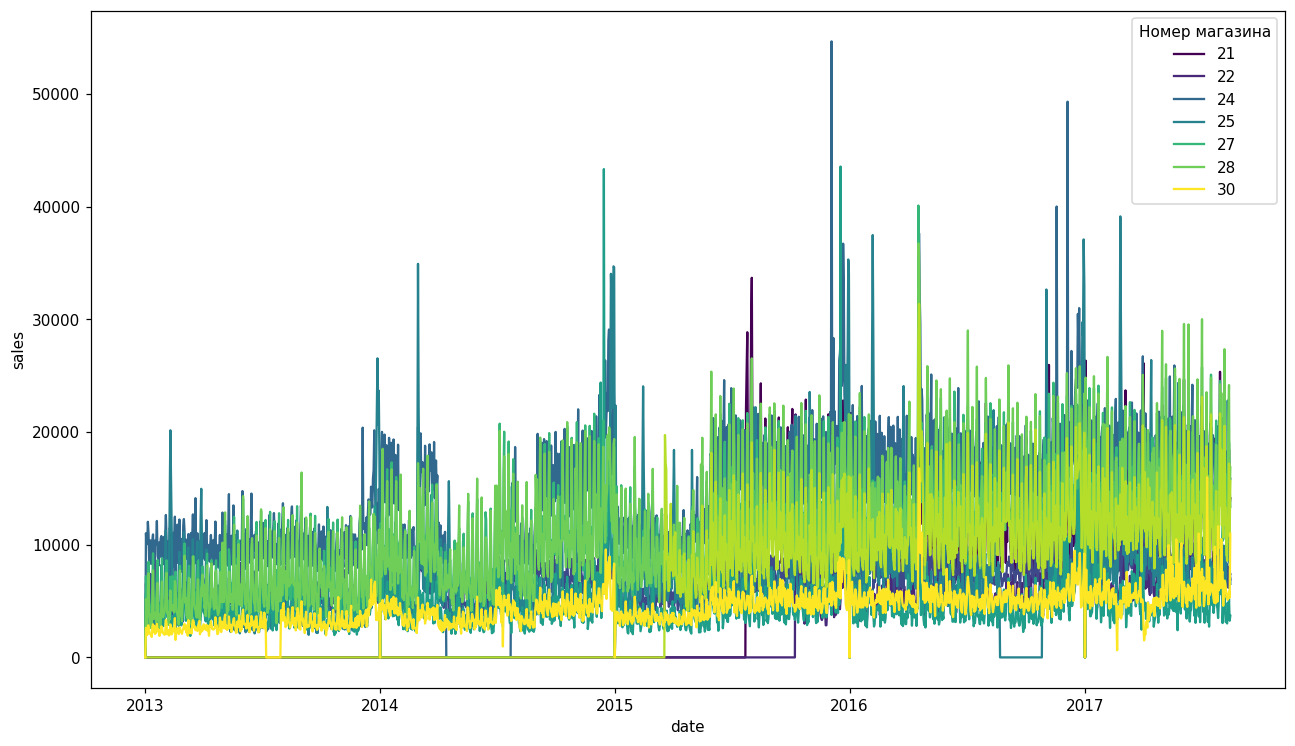

In [23]:
#Суммарные продажи по всем категориям за день. С Годом sales увеличивается
full_sales_by_store = df[df['sales'].notna()].groupby(by=['store_nbr','date'])['sales'].sum()
plot_df = full_sales_by_store[(21,):(30,)].reset_index()
plt.figure(figsize=(14,8), dpi=110)
sns.lineplot(plot_df, x='date', y='sales', hue='store_nbr', palette='viridis')
plt.legend(title='Номер магазина')

In [24]:
#df_holidays. На Test период приходится 1 праздник Fundacion de Ambato(24.08), следующий только через месяц. 
#15.08 был праздник Fundacion de Riobamba. Можно включить только их в выборку, а так же несколько дней до и после.
#Праздник будем описывать только названием
days_range = 4 #Сделаем интервал в 4 дня
holiday_names = ('Fundacion de Ambato', 'Fundacion de Riobamba')
add_holidays = pd.DataFrame()
for holiday_name in holiday_names:
    neighbour_days = make_neighbour_days(df_holidays, holiday_name, days_range)
    add_holidays = pd.concat([add_holidays, neighbour_days], axis=0, ignore_index=True)
df = df.merge(add_holidays, how='left', on='date')

In [25]:
#Работа с пропусками
df['description'] = df['description'].fillna('Normal')
df['dcoilwtico'] = df['dcoilwtico'].bfill()
getNanColumns(df)

[('sales', 28512)]

In [26]:
#Работа с признаками
#Магазин Однозначно описывается своим store_nbr, поэтому можно удалить другую информацию о магазине
df = df.drop(['city','state','type','cluster'], axis=1)
#Преобразуем store_nbr так, чтобы создать dummy-переменные
df['store'] = df['store_nbr'].map(getStoreName)
df = df.drop('store_nbr', axis=1)
#Создадим признак дня недели
df['weakday'] = df['date'].apply(lambda x: x.day_of_week)
df['weakday'] = df['weakday'].map({0:'Mod', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
#Создадим признак месяца
df['month'] = df['date'].apply(lambda x: x.month)
df['month'] = df['month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug',
                               9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
#Создадим признак года(дискретный)
df['year'] = df['date'].apply(lambda x: str(x.year))
#Удаляем ID
df = df.drop(['id'], axis=1)
#Добавим Time-step признак (кол-во дней с последней даты Train выборки)
df['time_step'] = df['date'] - df_train_origin['date'].max()
df['time_step'] = df['time_step'].apply(lambda x: x.days)
#Удаляем признак date
df = df.drop('date', axis=1)

In [28]:
#Для обучения возьмем последние 2 года
df_part = df[df['time_step']>=-700]

In [30]:
#Параметры модели
forecast_period = 16
forecast_day = 1

In [32]:
#Поиск лучшей модели
lags_amount_arr = [25,30,35]

model = XGBRegressor(max_depth=3)
pipe_model = Pipeline([('model', model)])
grid_params = {'model__n_estimators': [150,200,250]}
grid_model = GridSearchCV(pipe_model, grid_params, scoring='neg_root_mean_squared_error', cv=5, verbose=0)

for lags_amount in lags_amount_arr:
    findBestEstimator(grid_model,
                      df_part,
                      forecast_period,
                      forecast_day,
                      lags_amount)

Предсказание на 1-й день; Кол-во Lag-признаков = 25
Параметры = 150
Ошибка на данных = 0.8340913844910554
Предсказание на 1-й день; Кол-во Lag-признаков = 30
Параметры = 150
Ошибка на данных = 0.6724054452180651
Предсказание на 1-й день; Кол-во Lag-признаков = 35
Параметры = 150
Ошибка на данных = 0.7720361859134467


In [ ]:
final_result = pd.DataFrame()

In [ ]:
#Окончательные предсказания
final_forecast_day = 1

final_model = XGBRegressor(n_estimators=100, max_depth=3)
final_lags_amount = 15
result = findBestEstimator(final_model, 
                           df,
                           forecast_period,
                           final_forecast_day,
                           final_lags_amount)

final_result = pd.concat([final_result, result], axis=0, ignore_index=False)